### c) Load the segmentation image, and the corresponding CT image with PyDicom. Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers. Some relevant headers include:
* ‘Acquisition Number’.
* ‘Slice Index’.
* ‘Per-frame Functional Groups Sequence’ --> ‘Image Position Patient’.
* ‘Segment Identification Sequence’ --> ‘Referenced Segment Number’.

## Carga y visualización de las imágenes DICOM

#### Cargar Archivos DICOM
Cargo los archivos DICOM desde el directorio especificado. Trabajo inicialmente con un subconjunto de los archivos para testear.

**¿Con que CT trabajo? No me ha quedado claro qué subconjunto de archivos usar!**



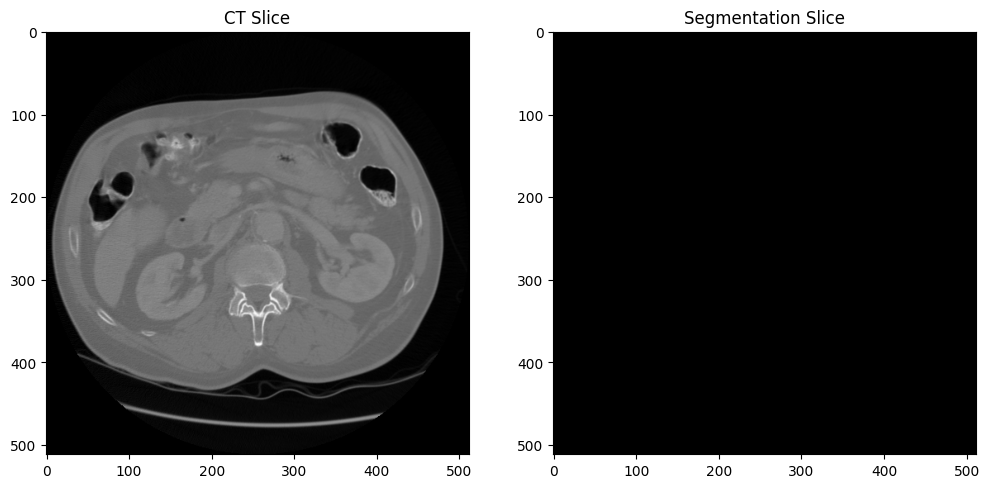

In [7]:
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to load a series of DICOM files
def load_dicom_series(directory):
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(x.InstanceNumber)) 
    return np.stack([file.pixel_array for file in files])

ct_directory = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008"
#ct_directory_2 = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636"
ct_images = load_dicom_series(ct_directory)

# Load Segmentation image
seg_file = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm"
seg_image = pydicom.dcmread(seg_file).pixel_array

# the segmentation is multi-slice and we visualize the middle one
mid_slice_index = seg_image.shape[0] // 2
seg_slice = seg_image[mid_slice_index, :, :]

# Visualizing one slice of CT and corresponding segmentation slice
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ct_images[mid_slice_index], cmap='gray')  # Same slice index for CT
plt.title('CT Slice')
plt.subplot(1, 2, 2)
plt.imshow(seg_slice, cmap='gray')  # Display the middle slice of segmentation
plt.title('Segmentation Slice')
plt.show()

#### Estudio de encabezados

#### Organización de las imágenes DICOM

Aqui uso el encabezado Image Position (Patient) para ordenar las imágenes.

In [9]:
# Rutas de las imágenes
segmented_image_path = 'C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg//HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm'
#ct_image_path = '/Users/pedromarti/Desktop/Master/AIM/Practica/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008/1-001.dcm'
ct_images_dir = 'C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636'

# Cargar las imágenes
segmentation_image = pydicom.dcmread(segmented_image_path) # Cargar imagen de segmentación

# Cargar imágenes de CT
ct_files = [f for f in os.listdir(ct_images_dir) if f.endswith('.dcm')]
ct_images = [pydicom.dcmread(os.path.join(ct_images_dir, f)) for f in ct_files]

# Verificar la uniformidad de 'Acquisition Number'
acquisition_numbers = set(img.AcquisitionNumber for img in ct_images)
if len(acquisition_numbers) > 1:
    raise ValueError("Multiple acquisition numbers found. Ensure all CT images are from a single acquisition.")

# Organización de imágenes CT según 'Image Position Patient'
ct_images.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Mostrar detalles relevantes
print("Details of CT images sorted by Image Position Patient:")
for img in ct_images:
    print(f"Acquisition Number: {img.AcquisitionNumber}, Image Position Patient: {img.ImagePositionPatient}")

# Preparación de arrays de píxeles
segmentation_array = segmentation_image.pixel_array
ct_arrays = np.stack([img.pixel_array for img in ct_images])

print("Dimensiones del arreglo de segmentación:", segmentation_array.shape)
print("Dimensiones del arreglo de imágenes CT:", ct_arrays.shape)

Details of CT images sorted by Image Position Patient:
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -254.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -244.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -234.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -224.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -214.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -204.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -194.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -184.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -174.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -164.729996]
Acquisition Number: 1, Image Position Patient: [-203.500000, -180.000000, -

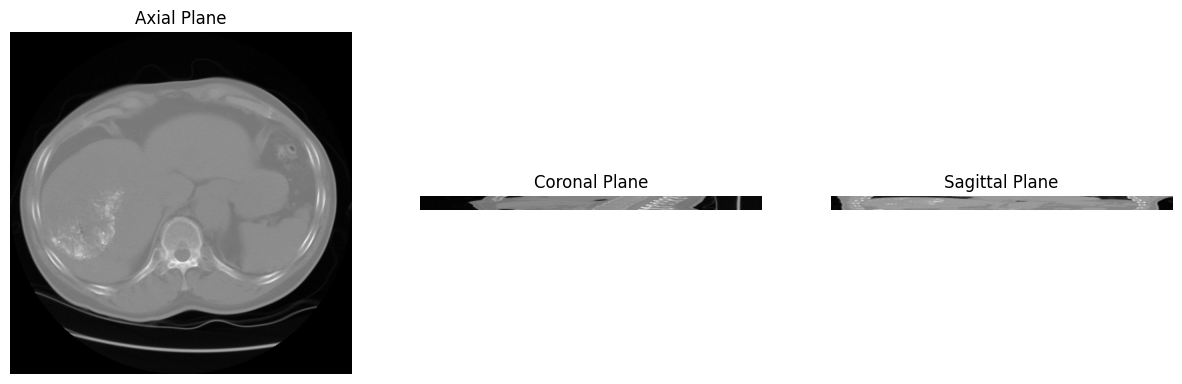

In [10]:
def visualize_planes(ct_volume):
    # Extraer los planos coronal y sagital
    coronal_plane = ct_volume[:, :, ct_volume.shape[2]//2]  # slice en el medio del eje X
    sagittal_plane = ct_volume[:, ct_volume.shape[1]//2, :]  # slice en el medio del eje Y
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ct_volume[ct_volume.shape[0]//2], cmap='gray')  # Plano axial
    axes[0].set_title('Axial Plane')
    axes[1].imshow(coronal_plane, cmap='gray', origin='lower')
    axes[1].set_title('Coronal Plane')
    axes[2].imshow(sagittal_plane, cmap='gray', origin='lower')
    axes[2].set_title('Sagittal Plane')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# Visualizar los planos
visualize_planes(ct_arrays)

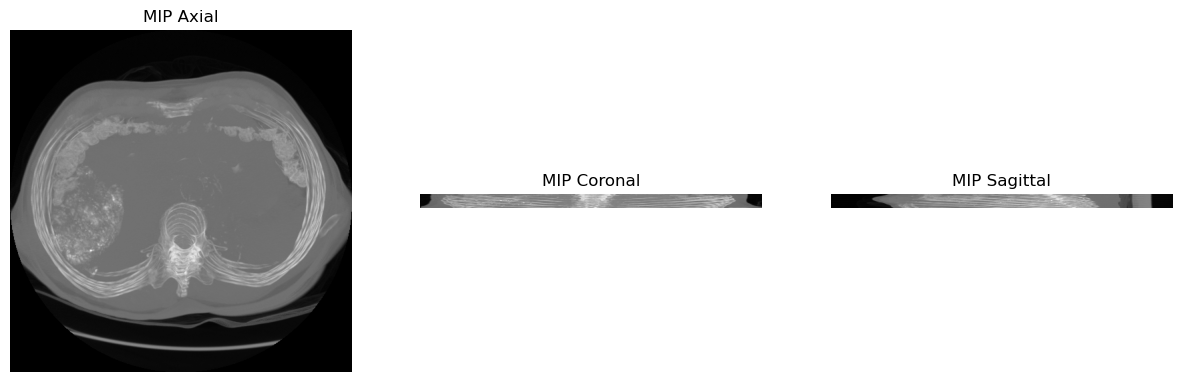

In [104]:
def create_mip(ct_volume):
    mip_axial = np.max(ct_volume, axis=0)
    mip_coronal = np.max(ct_volume, axis=1)
    mip_sagittal = np.max(ct_volume, axis=2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(mip_axial, cmap='gray')
    axes[0].set_title('MIP Axial')
    axes[1].imshow(mip_coronal, cmap='gray')
    axes[1].set_title('MIP Coronal')
    axes[2].imshow(mip_sagittal, cmap='gray')
    axes[2].set_title('MIP Sagittal')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

# Generar y visualizar MIP
create_mip(ct_arrays)


## Visualización

#### Pregunta: ¿Hem d'aplicar una transformació d'intensitat per a que l'image es visualitzi millor (Windowing)? T2 pg 28-33

Visualización de correspondencias

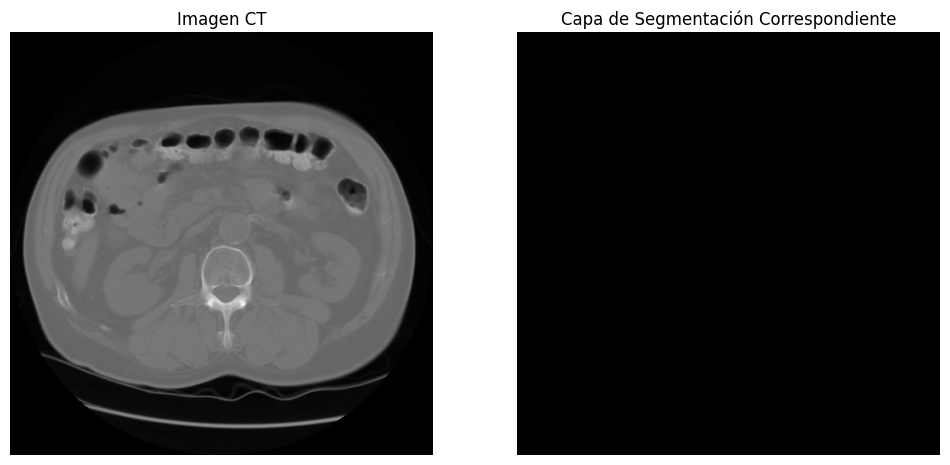

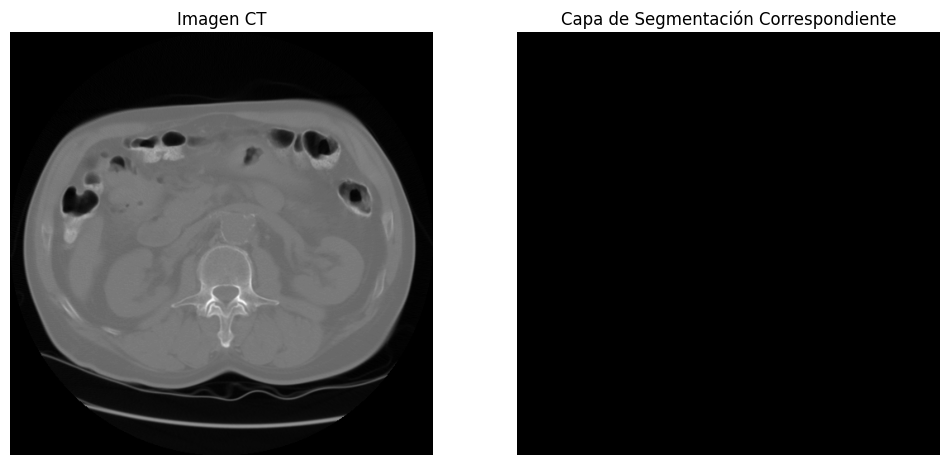

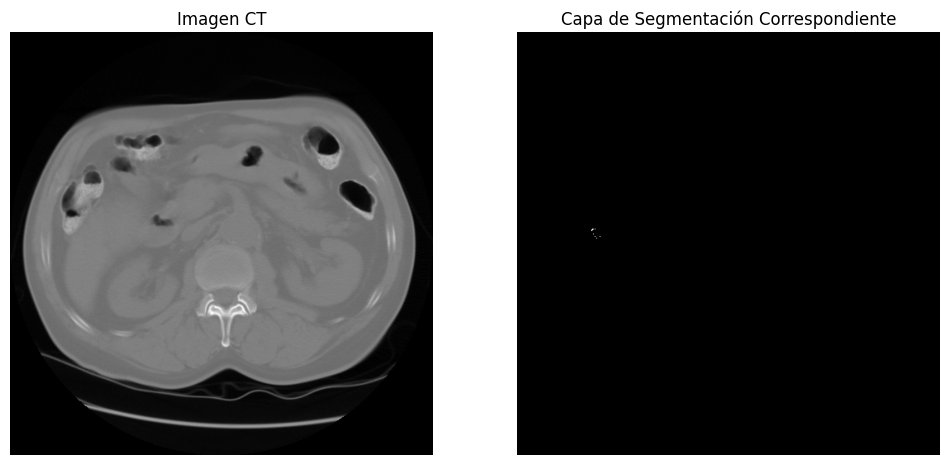

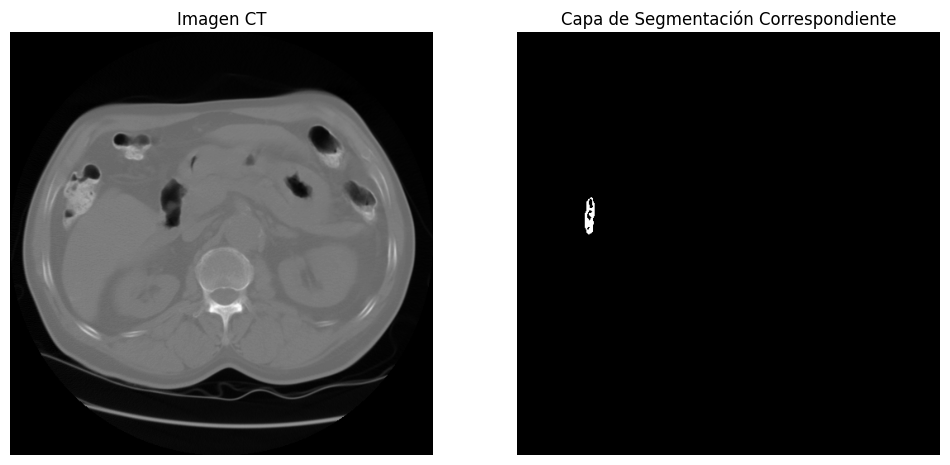

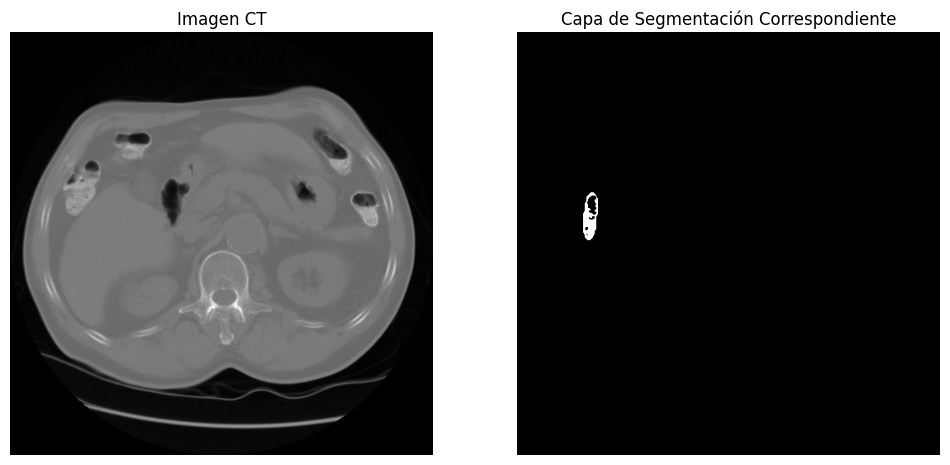

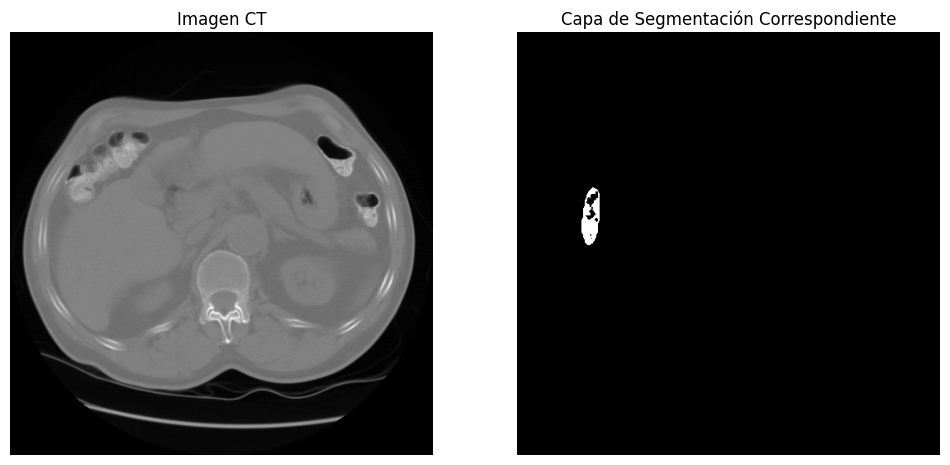

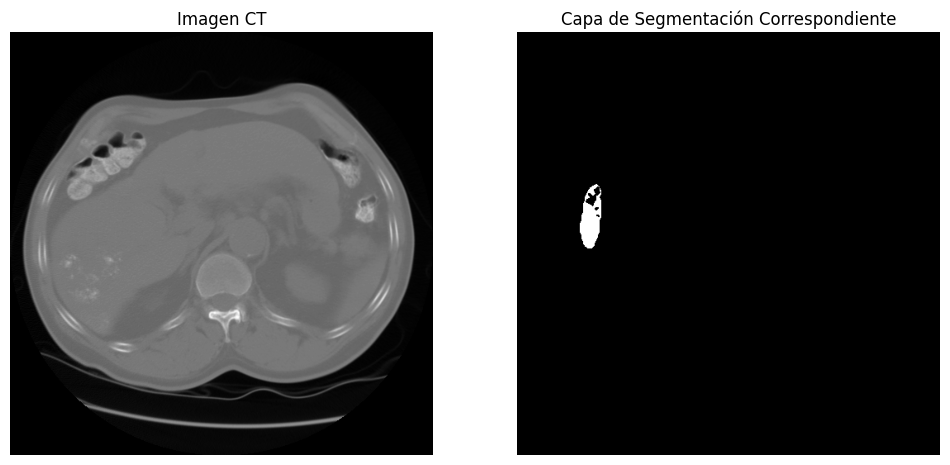

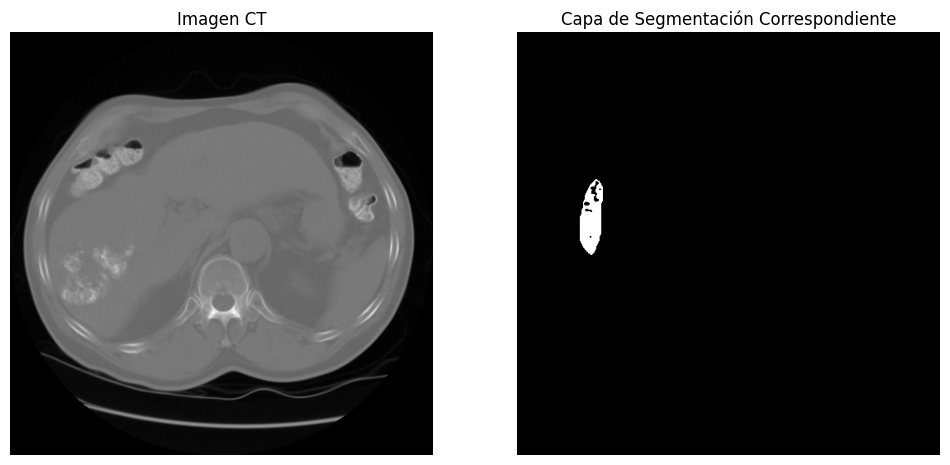

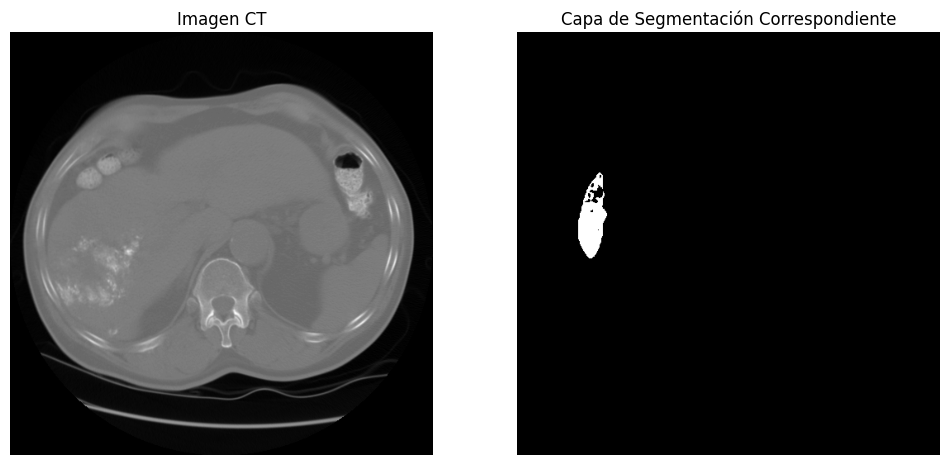

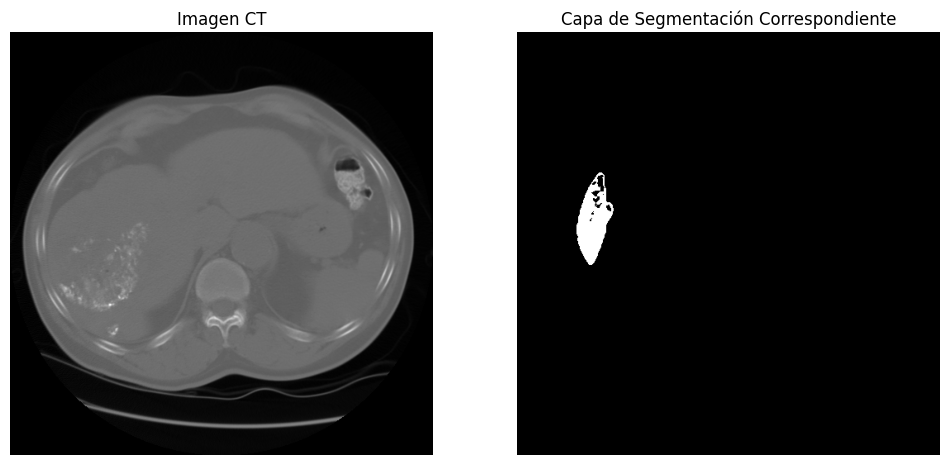

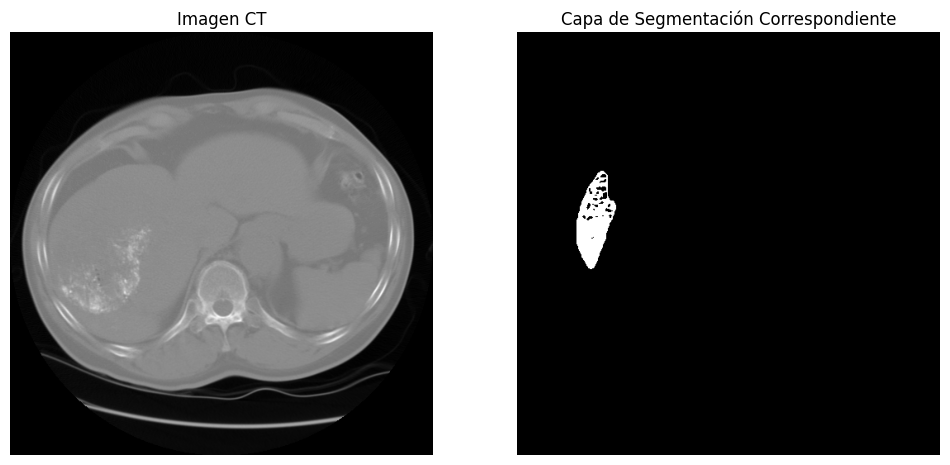

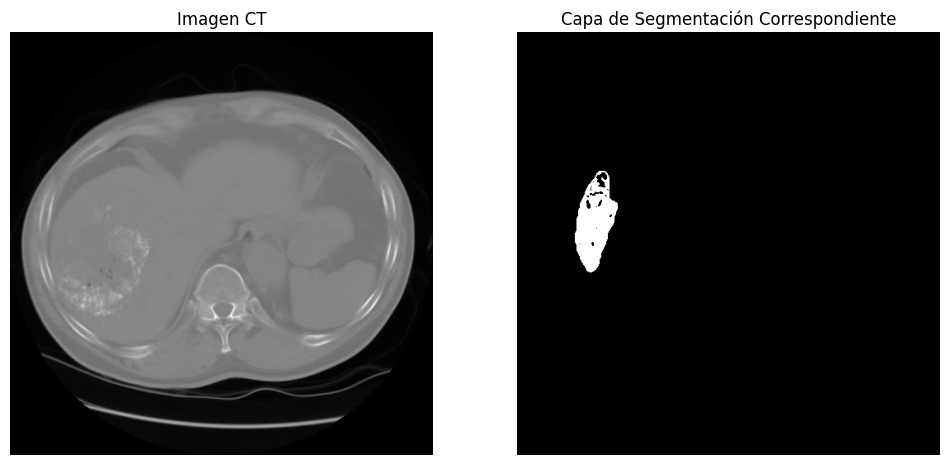

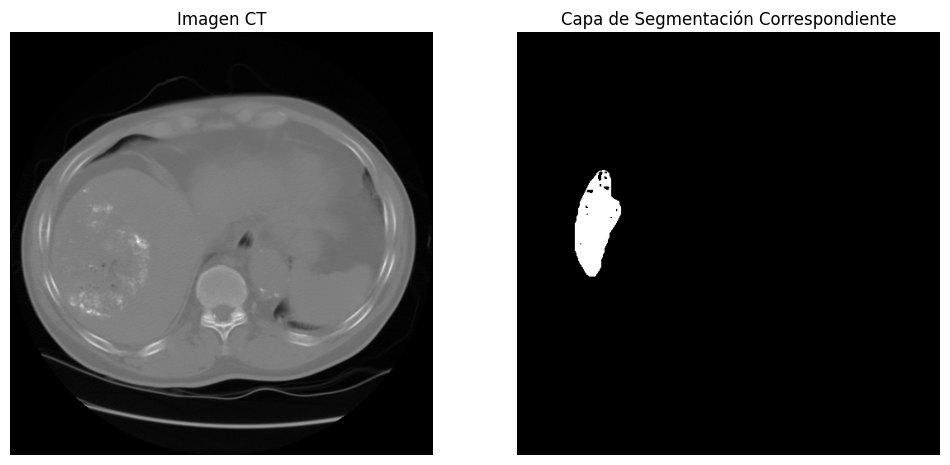

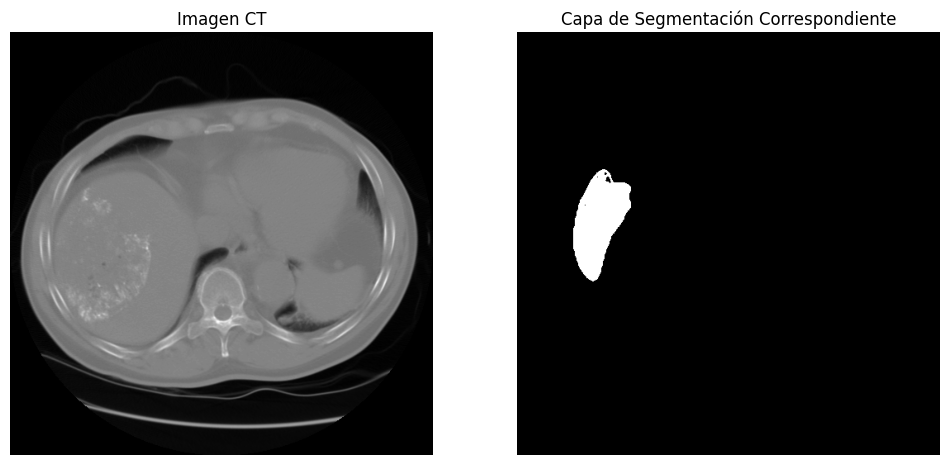

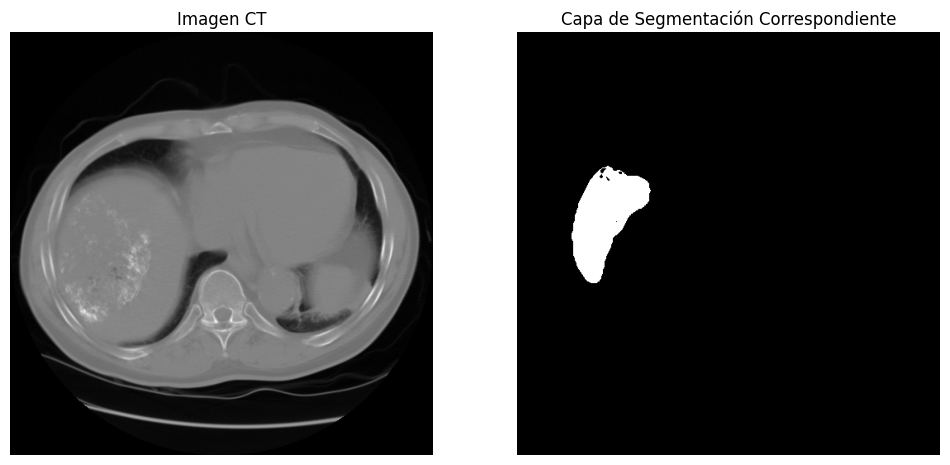

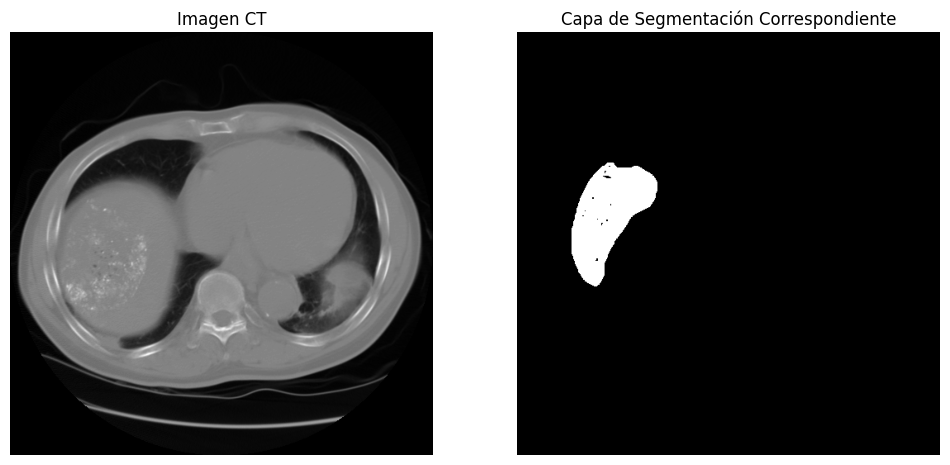

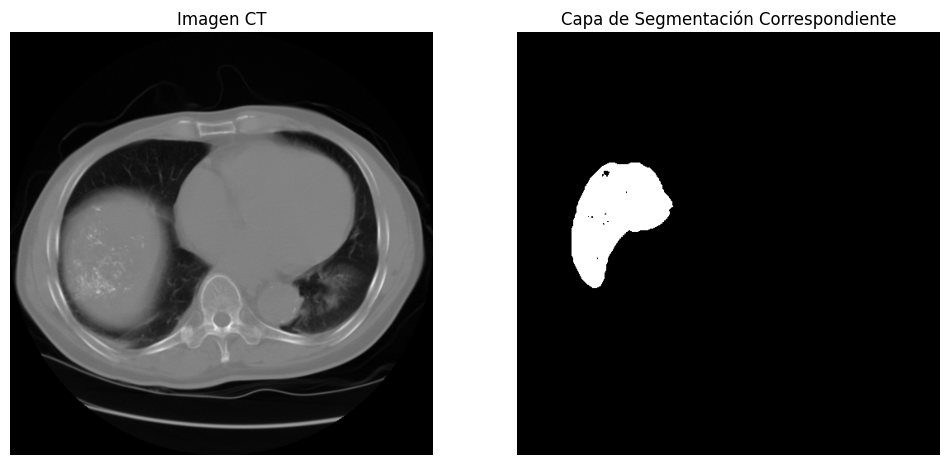

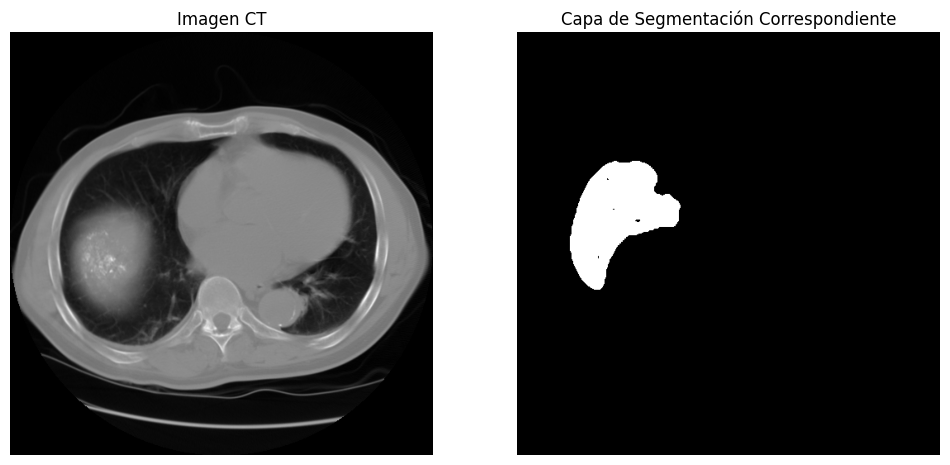

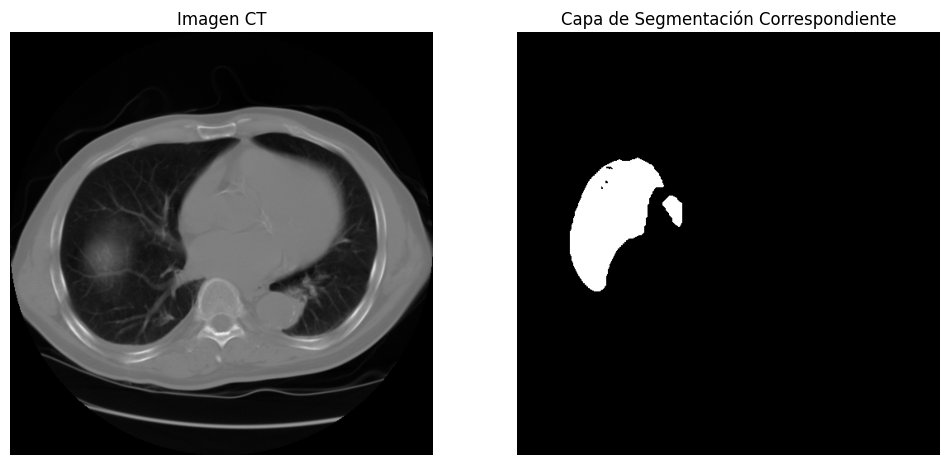

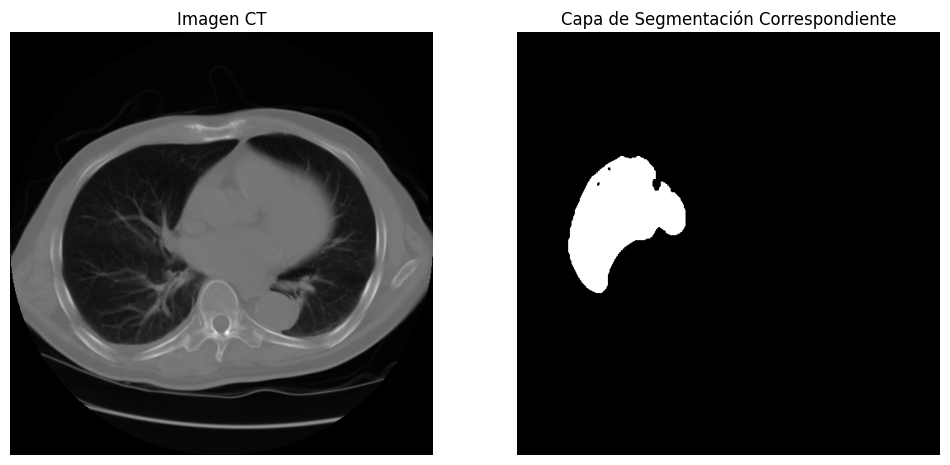

In [11]:
# Función para visualizar imágenes CT y de segmentación
def plot_images(ct_image, segmentation_layer):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(ct_image, cmap='gray')
    ax[0].set_title('Imagen CT')
    ax[0].axis('off')

    ax[1].imshow(segmentation_layer, cmap='gray')
    ax[1].set_title('Capa de Segmentación Correspondiente')
    ax[1].axis('off')

    plt.show()

# Suponiendo que cada capa de segmentación corresponde directamente a cada imagen CT (esto es solo un ejemplo)
for i in range(len(ct_arrays)):
    plot_images(ct_arrays[i], segmentation_array[i])


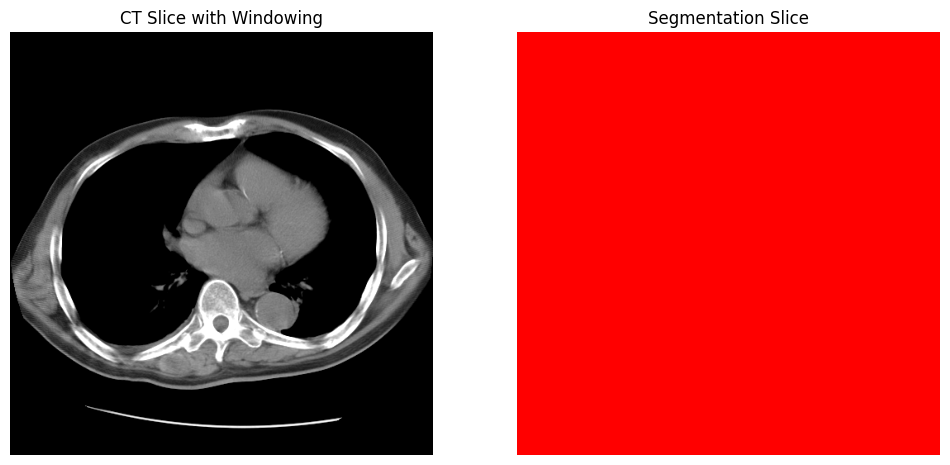

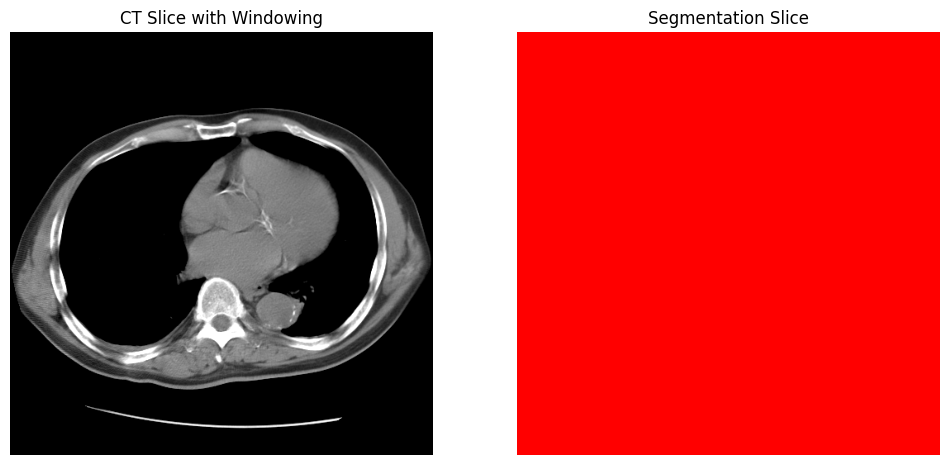

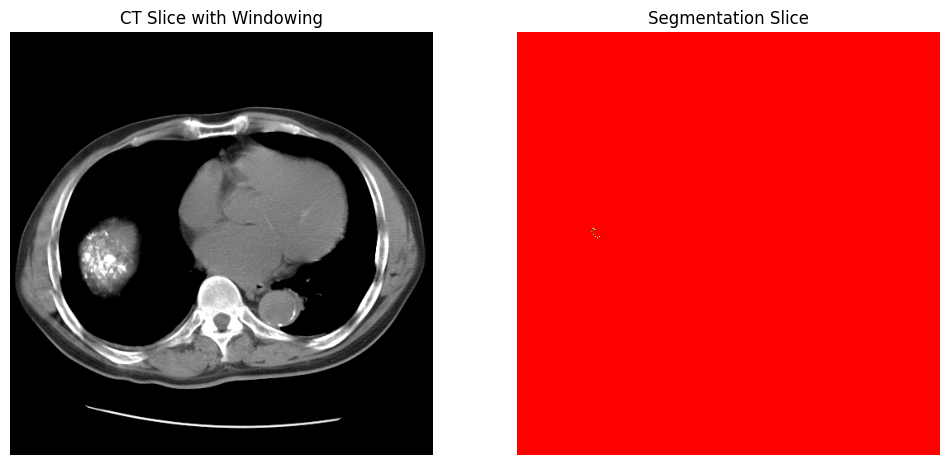

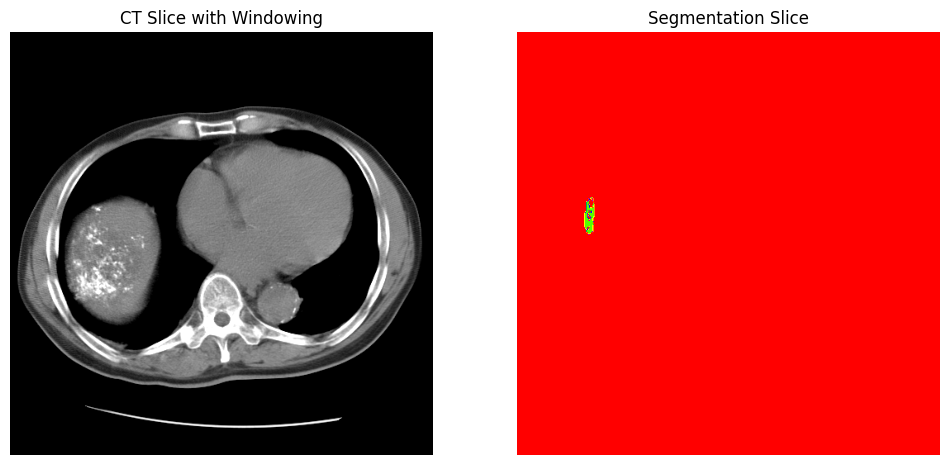

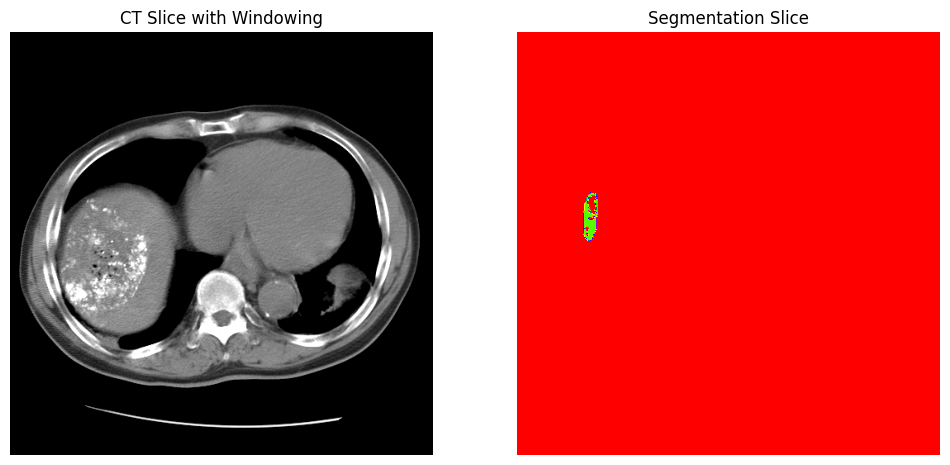

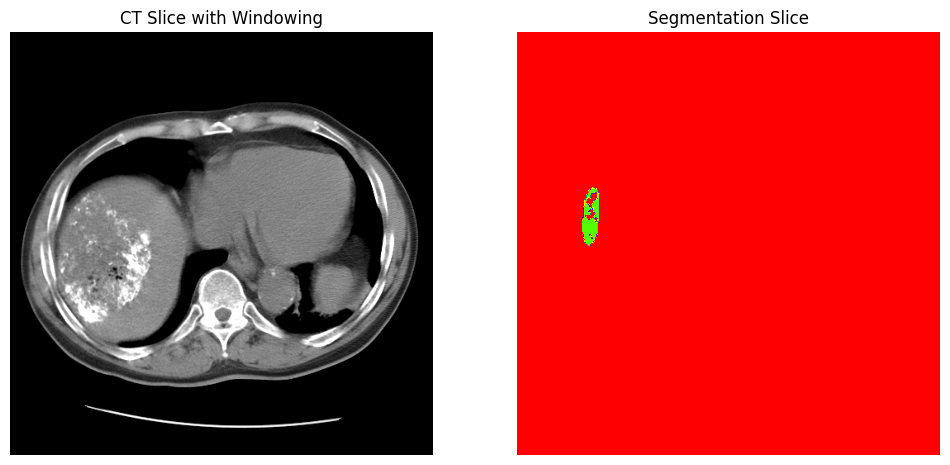

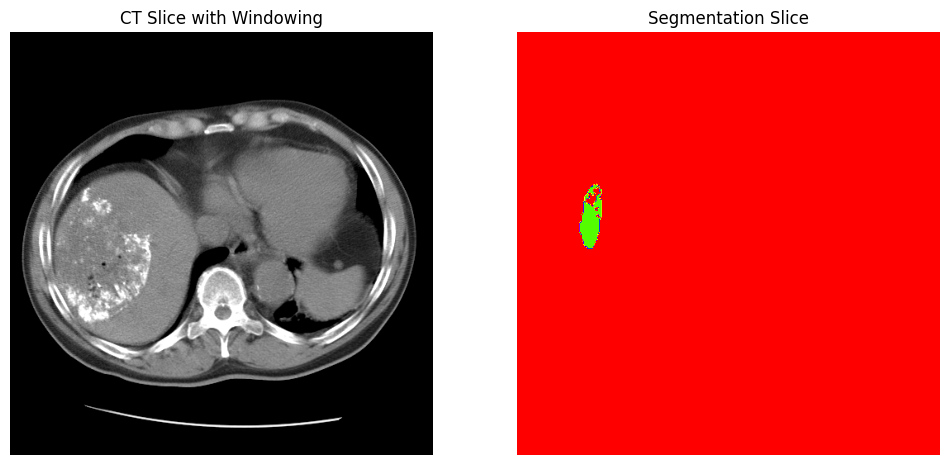

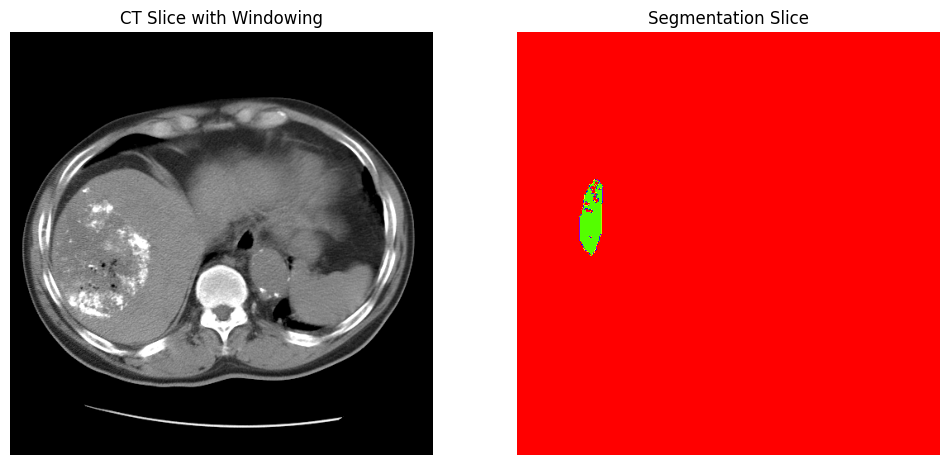

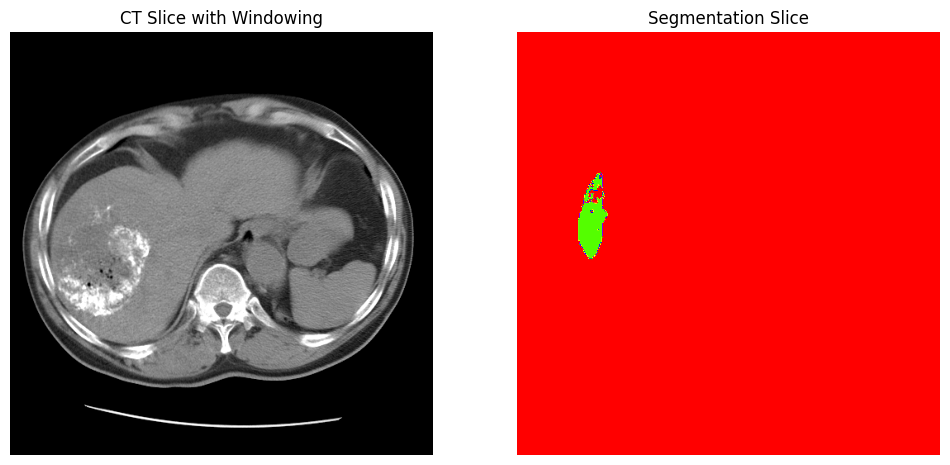

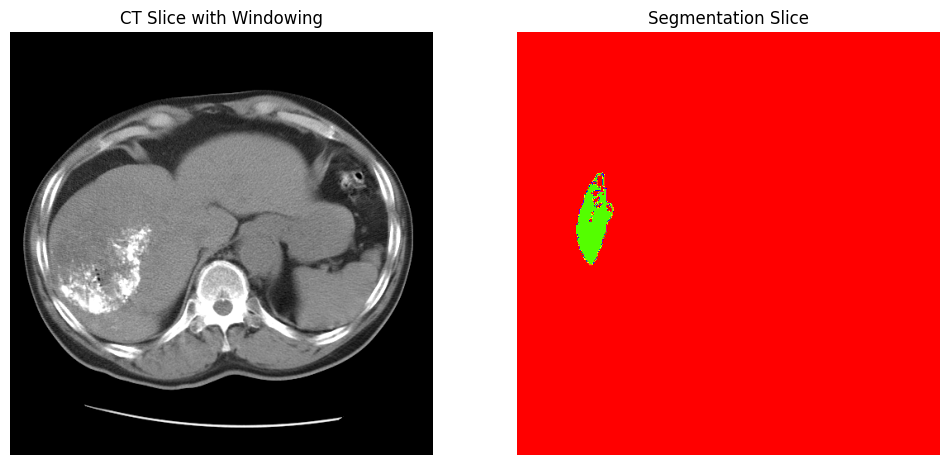

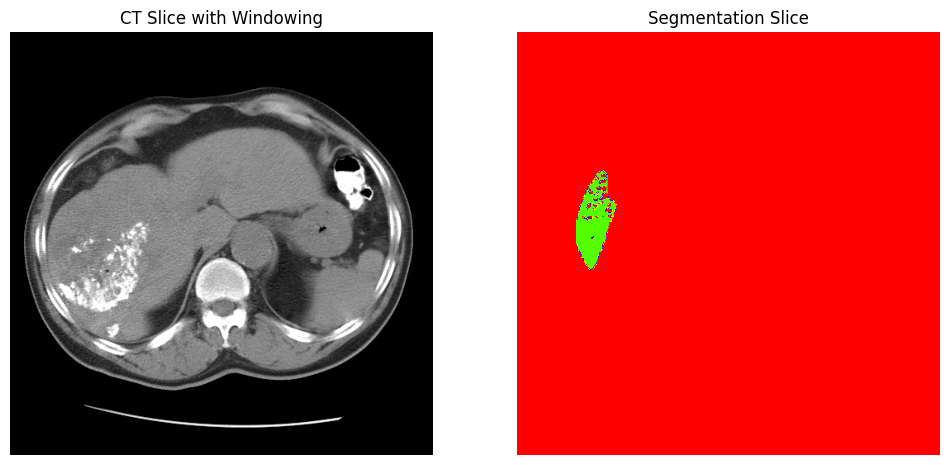

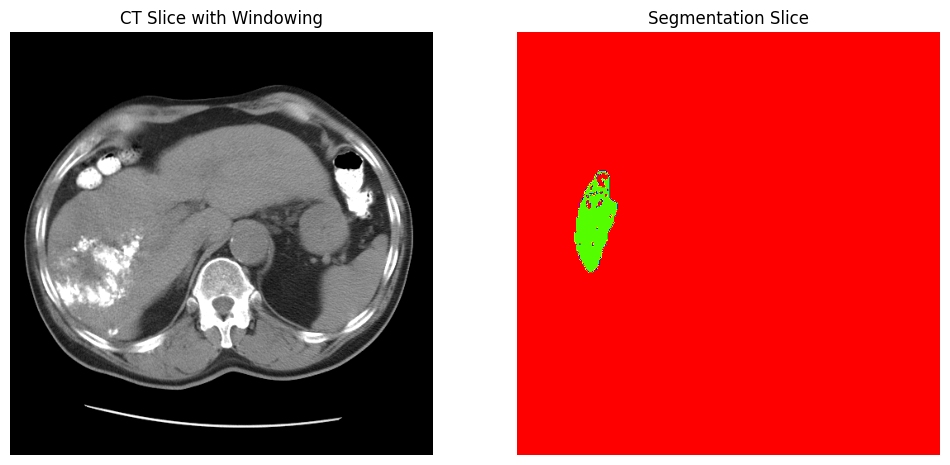

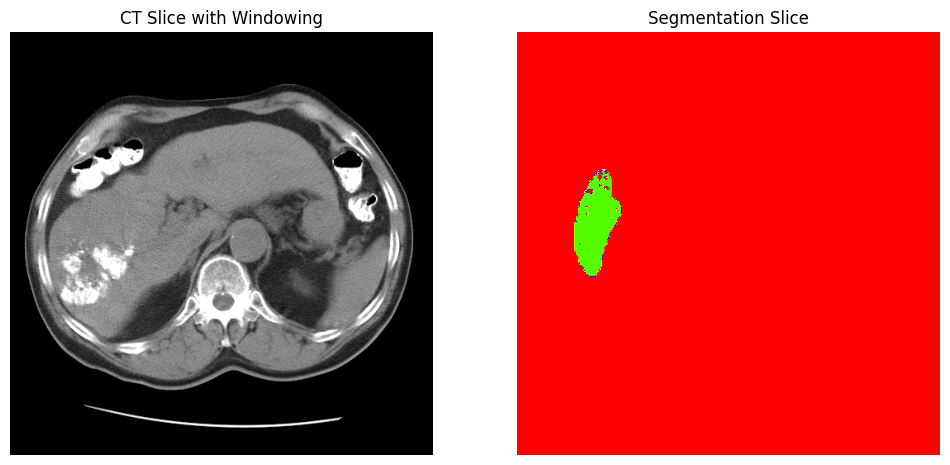

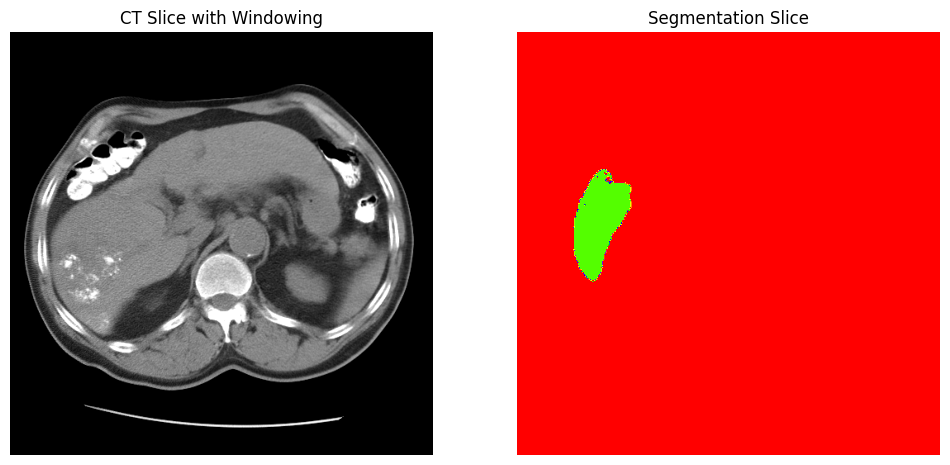

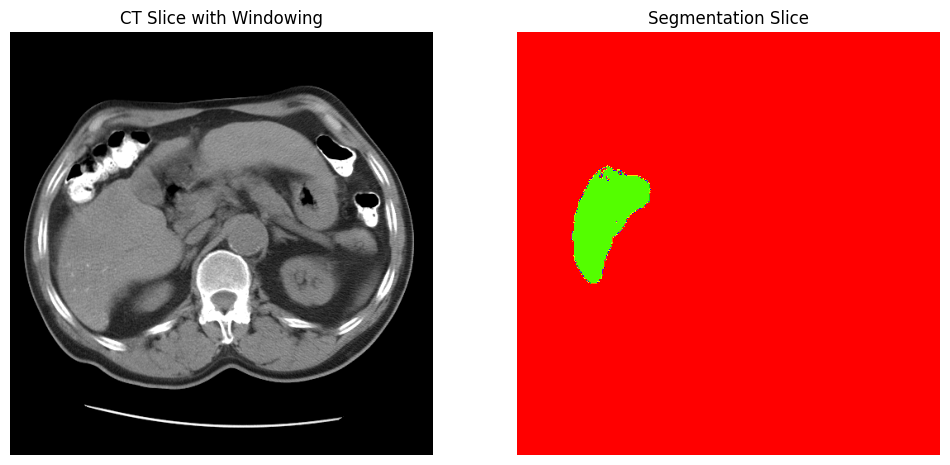

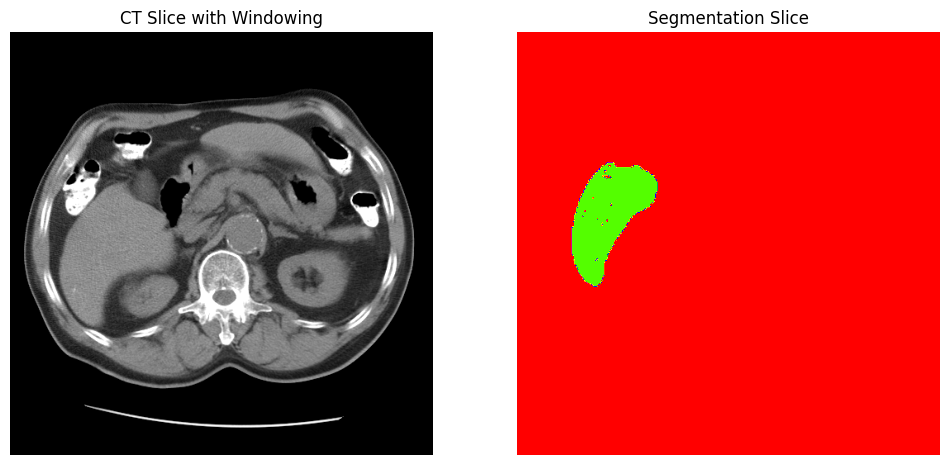

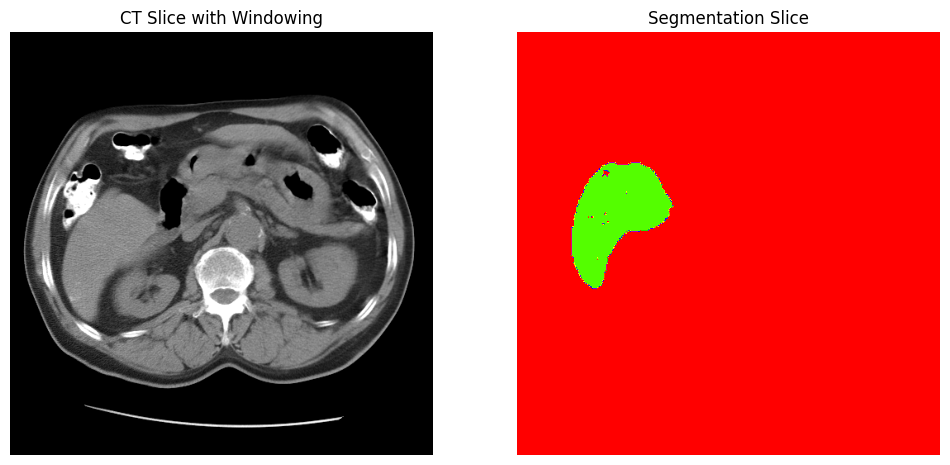

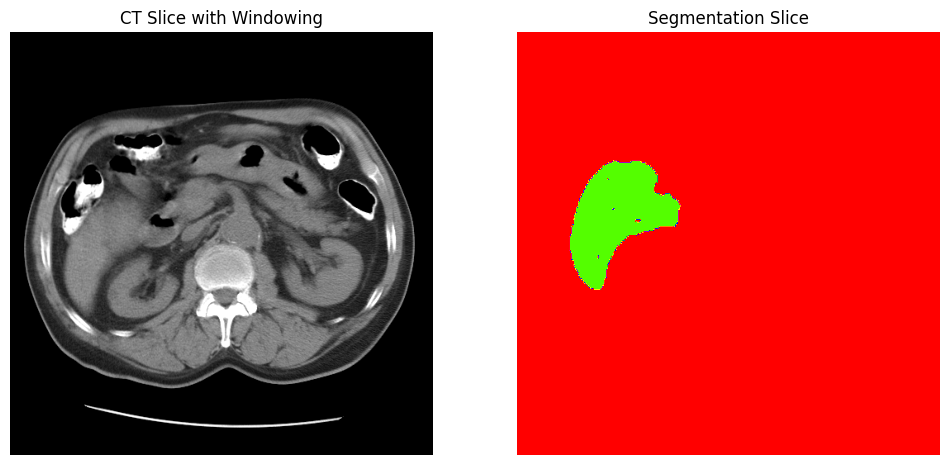

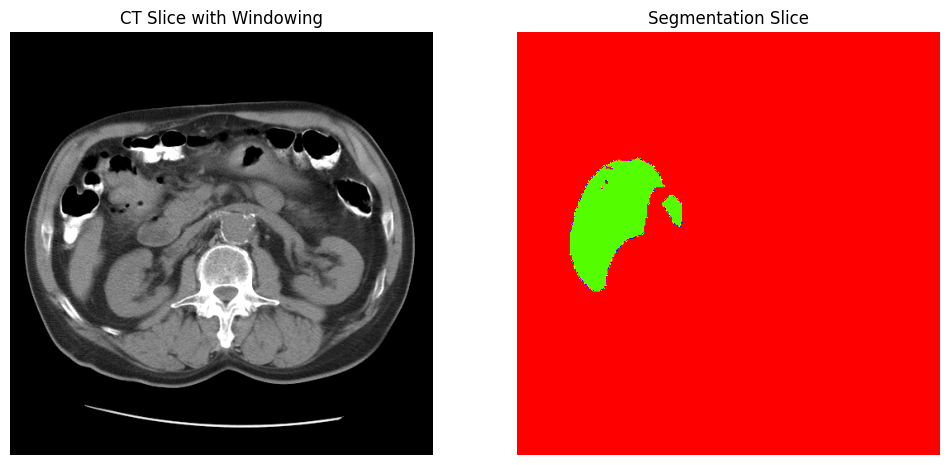

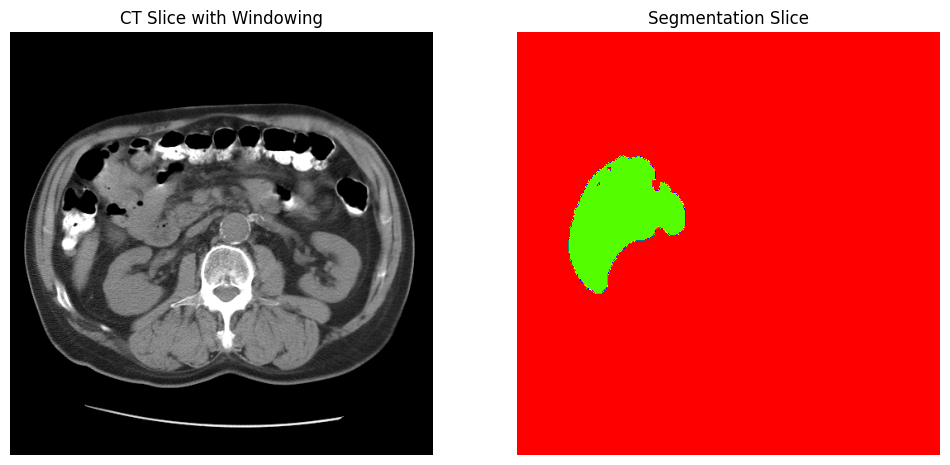

In [35]:
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to apply windowing: C = (I - WL + 0.5 * WW) / WW
def apply_window(image, window_center, window_width):
    lower_bound = window_center - 0.5 * window_width
    upper_bound = window_center + 0.5 * window_width
    return np.clip((image - lower_bound) / window_width, 0, 1)

# Function to load and apply windowing to a series of DICOM files
def load_dicom_series_with_windowing(directory, window_center, window_width):
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(x.InstanceNumber))
    images = np.stack([file.pixel_array for file in files])
    return np.stack([apply_window(img, window_center, window_width) for img in images])

# Load and visualize CT images with windowing
window_center, window_width = 40, 400  # Typical abdomen settings
ct_images = load_dicom_series_with_windowing(ct_directory, window_center, window_width)

# Visualization function including colormap for segmentation
def plot_images_with_colormap(ct_image, segmentation_layer):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(ct_image, cmap='gray') #Colormap
    ax[0].set_title('CT Slice with Windowing')
    ax[0].axis('off')

    ax[1].imshow(segmentation_layer, cmap='prism')  # Use a color map that highlights different regions
    ax[1].set_title('Segmentation Slice')
    ax[1].axis('off')

    plt.show()

# Demonstrate the visualization for a few slices
for i in range(len(ct_images)):  # Just show first 5 slices as an example
    plot_images_with_colormap(ct_images[i], seg_image[i])


## MIP

In [39]:
def mip(image_stack, axis=0):
    return np.max(image_stack, axis=axis)

# Create projections
def create_mip_animations(image_stack):
    fig, ax = plt.subplots()
    ims = []

    for angle in np.linspace(0, 360, num=36, endpoint=False):
        rotated = rotate(image_stack, angle, axes=(1, 2), reshape=False, mode='nearest')
        mip_image = mip(rotated, axis=0)
        im = ax.imshow(mip_image, cmap='gray', animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
    ani.save('mip_rotation.gif', writer='imagemagick')
    plt.show()


In [47]:
def calculate_mip(ct_volume, axis):
    """ Calculate the Maximum Intensity Projection (MIP) along a given axis. """
    return np.max(ct_volume, axis=axis)  # axis=1 collapses the Y-axis


In [51]:
import matplotlib.pyplot as plt

def visualize_mip_planes(ct_volume):
    mip_sagittal = calculate_mip(ct_volume,1)
    mip_coronal = calculate_mip(ct_volume,2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mip_sagittal, cmap='gray')
    plt.title('MIP Sagittal Plane')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mip_coronal, cmap='gray')
    plt.title('MIP Coronal Plane')
    plt.axis('off')

    plt.show()


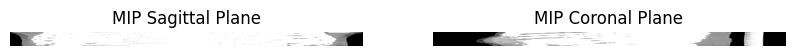

In [52]:
visualize_mip_planes(ct_images)